<a href="https://colab.research.google.com/github/zekzen/dataclub/blob/main/4_cardiovascular_disease_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-
"""
İU Data Klubu - Yapay Sinir Aglari Sunumu
07.04.2021
Author: Dr. Zeki Ozen

Dataset kaynagi: Cardiovascular Disease dataset @ Kaggle
Link: https://www.kaggle.com/sulianova/cardiovascular-disease-dataset


    PyTorch yeni baslayanlar icin guzel bir anlatim ve uygulama linki:
    https://www.freecodecamp.org/news/how-to-build-a-neural-network-with-pytorch/
    
Faydalanilan PyTorch Kod Kaynaklari:  
    https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/
    https://www.kaggle.com/kanncaa1/pytorch-tutorial-for-deep-learning-lovers
    


"""

In [4]:
# standart kutuphanelerimiz
import numpy as np
import pandas as pd

In [5]:
# veri seti yukleyelim
data = pd.read_csv('https://raw.githubusercontent.com/zekzen/dataclub/main/cardio.csv', sep=';')
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
#id sutunu kaldiriliyor
data.drop('id',axis=1,inplace=True)

In [8]:
#yas sutunu
#data.age = np.round(data.age/365.25,decimals=1)

#gender sutununda 2 ile temsil edilen veriyi 0 yapiyoruz
data.gender = data.gender.replace(2,0)

In [9]:
#cinsiyet degerleri kacar tane var
data.gender.value_counts()

1    45530
0    24470
Name: gender, dtype: int64

In [10]:
# vucut kutle indeksini hesaplayip veri setimize ekliyoruz
data['bmi'] = data.weight / (data.height / 100) ** 2
# height ve weight kolonlarina artik gere kalmadigi icin kaldiriyoruz
data.drop('height', axis=1,inplace=True)
data.drop('weight', axis=1,inplace=True)

In [11]:
#bagimli ve bagimsiz degiskenelr ayarlaniyor
X = data[data.columns.difference(['cardio'])]
y = pd.DataFrame(data['cardio'])

In [12]:
# Egitim ve test veri setlerini 80-20 oraninda ayarliyoruz
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 47339 to 15795
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   active       56000 non-null  int64  
 1   age          56000 non-null  int64  
 2   alco         56000 non-null  int64  
 3   ap_hi        56000 non-null  int64  
 4   ap_lo        56000 non-null  int64  
 5   bmi          56000 non-null  float64
 6   cholesterol  56000 non-null  int64  
 7   gender       56000 non-null  int64  
 8   gluc         56000 non-null  int64  
 9   smoke        56000 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 4.7 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 56000 entries, 47339 to 15795
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   cardio  56000 non-null  int64
dtypes: int64(1)
memory usage: 875.0 KB
None


In [13]:
#bagimli numerik degiskenler normalize ediliyor
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
#numerik degiskenler 
to_be_scaled_feat = ['age', 'ap_hi', 'ap_lo','bmi']
scaler=StandardScaler()
scaler.fit(X_train[to_be_scaled_feat])
X_train[to_be_scaled_feat] = scaler.transform(X_train[to_be_scaled_feat])
X_test[to_be_scaled_feat] = scaler.transform(X_test[to_be_scaled_feat])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [14]:
#bagimli kategorik degiskenler one-hot-encoding yontemi ile kategorik formata donusturuluyor
X_train = pd.get_dummies( X_train, columns= ["gender", 'cholesterol',  'gluc',  'smoke', 'alco', 'active'], drop_first=True)
X_test = pd.get_dummies( X_test, columns= ["gender", 'cholesterol',  'gluc',  'smoke', 'alco', 'active'], drop_first=True)

In [15]:
# pytorch kutuphanesini calisma alanimiza dahil ediyoruz
import torch
from torch import nn, optim
import torch.nn.functional as F

In [16]:
# egitim ve test veri setlerimizin
# bagimli ve bagimsiz degiskenlerini torch yapisina donusturuyoruz
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([56000, 12]) torch.Size([56000])
torch.Size([14000, 12]) torch.Size([14000])


In [17]:
# modelin dogrulugunu hesaplayacak fonksiyon
def calculate_accuracy(y_true, y_pred):
  predicted = y_pred.ge(.5).view(-1)
  return (y_true == predicted).sum().float() / len(y_true)

In [18]:
# sonuclari yuvarlayacak fonksiyon
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

In [19]:
# Yapay sinir mimarisi bu sinif ile olusturuluyor
class Net(nn.Module):
    
  def __init__(self, n_features):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(n_features, 5)
    self.fc2 = nn.Linear(5, 3)
    self.fc3 = nn.Linear(3, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

In [24]:
# Yapilandirdigimiz modelin girdi katmani boyutu, hata fonk, optimizasyon fonk. gibi 
# parametrelerini veriyoruz
net = Net(X_train.shape[1])

In [25]:
# hata hesaplama metrigimiz
#criterion = nn.BCELoss()
criterion = nn.MSELoss()

In [26]:
# ogrenme fonksiyonumuz ve ogrenme orani
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [27]:
# hesaplamada kullanilacak degiskenlerimiz
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

In [28]:
# modelin egitimi yapiliyor
for epoch in range(1000):

    
    #egitim verisiyle model kuruluyor ve cikti tahmin ediliyor
    y_pred = net(X_train)
    y_pred = torch.squeeze(y_pred)
    #egitim verisindeki tahmin hatasi hesaplaniyor
    train_loss = criterion(y_pred, y_train)
    

    # her 100 iterasyonda bir hata hesapliyoruz      
    if epoch % 100 == 0:
      train_acc = calculate_accuracy(y_train, y_pred)
      y_test_pred = net(X_test)
      y_test_pred = torch.squeeze(y_test_pred)
      test_loss = criterion(y_test_pred, y_test)
      test_acc = calculate_accuracy(y_test, y_test_pred)

      loss_list.append(test_loss.data)
      iteration_list.append(count)
      accuracy_list.append(train_acc)
    
      print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')

    # Clear gradients
    optimizer.zero_grad()
    
    # Calculating gradients
    train_loss.backward()
    # Update parameters
    optimizer.step()
    count += 1

epoch 0
Train set - loss: 0.255, accuracy: 0.501
Test  set - loss: 0.256, accuracy: 0.499

epoch 100
Train set - loss: 0.236, accuracy: 0.624
Test  set - loss: 0.235, accuracy: 0.631

epoch 200
Train set - loss: 0.228, accuracy: 0.644
Test  set - loss: 0.226, accuracy: 0.65

epoch 300
Train set - loss: 0.22, accuracy: 0.659
Test  set - loss: 0.219, accuracy: 0.666

epoch 400
Train set - loss: 0.208, accuracy: 0.683
Test  set - loss: 0.206, accuracy: 0.688

epoch 500
Train set - loss: 0.198, accuracy: 0.709
Test  set - loss: 0.196, accuracy: 0.713

epoch 600
Train set - loss: 0.19, accuracy: 0.724
Test  set - loss: 0.189, accuracy: 0.727

epoch 700
Train set - loss: 0.187, accuracy: 0.728
Test  set - loss: 0.187, accuracy: 0.73

epoch 800
Train set - loss: 0.186, accuracy: 0.732
Test  set - loss: 0.185, accuracy: 0.733

epoch 900
Train set - loss: 0.185, accuracy: 0.733
Test  set - loss: 0.184, accuracy: 0.737



In [29]:
# performans degerlendirme icin gerekli standart kutuphaneler
from sklearn.metrics import classification_report, accuracy_score
y_pred = net(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.77      0.74      6988
         1.0       0.75      0.70      0.73      7012

    accuracy                           0.74     14000
   macro avg       0.74      0.74      0.73     14000
weighted avg       0.74      0.74      0.73     14000

0.7352142857142857


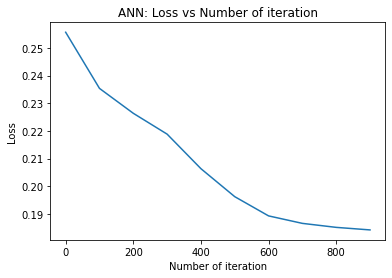

In [30]:
# her bir iterasyonda kayip (hata) grafigi
import matplotlib.pyplot as plt
# visualization loss 
plt.plot(iteration_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("ANN: Loss vs Number of iteration")
plt.show()

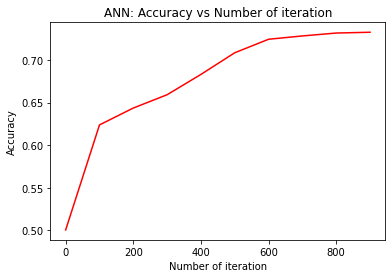

In [31]:
# her bir iterasyonda modelin dogruluk grafigi
plt.plot(iteration_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("ANN: Accuracy vs Number of iteration")
plt.show()